## General Information

This notebook is used to train a simple neural network model to predict the chemistry in the barite benchmark (50x50 grid). The training data is stored in the repository using **git large file storage** and can be downloaded after the installation of git lfs using the `git lfs pull` command.

It is then recommended to create a Python environment using miniconda. The necessary dependencies are contained in `environment.yml` and can be installed using `conda env create -f environment.yml`.

The data set is divided into a design and result part and consists of the iterations of a reference simulation. The design part of the data set contains the chemical concentrations at time $t$ and the result part at time $t+1$, which are to be learned by the model.

## Setup Libraries

In [2]:
import keras
print("Running Keras in version {}".format(keras.__version__))

import h5py
import numpy as np
import pandas as pd
import time
import sklearn.model_selection as sk
import matplotlib.pyplot as plt

Running Keras in version 3.8.0


## Define parameters

In [3]:
dtype = "float32"
activation = "relu"

lr = 0.001
batch_size = 512
epochs = 50 # default 400 epochs

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps=2000,
    decay_rate=0.9,
    staircase=True
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
loss = keras.losses.Huber()

sample_fraction = 0.8

## Setup the model

In [4]:
model = keras.Sequential(
    [
        keras.Input(shape = (12,), dtype = "float32"),
        keras.layers.Dense(units = 128, activation = "relu", dtype = "float32"),
        keras.layers.Dense(units = 128, activation = "relu", dtype = "float32"),
        keras.layers.Dense(units = 12, dtype = "float32")
    ]
)

model.compile(optimizer=optimizer, loss = loss)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,724 (77.05 KB)

 Trainable params: 19,724 (77.05 KB)

 Non-trainable params: 0 (0.00 B)

## Define some functions and helper classes

In [5]:
def Safelog(val):
    # get range of vector
    if val > 0:
        return np.log10(val)
    elif val < 0:
        return -np.log10(-val)
    else:
        return 0

def Safeexp(val):
    if val > 0:
        return -10 ** -val
    elif val < 0:
        return 10 ** val
    else:
        return 0


In [6]:
# ? Why does the charge is using another logarithm than the other species

func_dict_in = {
    "H" : np.log1p,
    "O" : np.log1p,
    "Charge" : Safelog,
    "H_0_" : np.log1p,
    "O_0_" : np.log1p,
    "Ba" : np.log1p,
    "Cl" : np.log1p,
    "S_2_" : np.log1p,
    "S_6_" : np.log1p,
    "Sr" : np.log1p,
    "Barite" : np.log1p,
    "Celestite" : np.log1p
}

func_dict_out = {
    "H" : np.expm1,
    "O" : np.expm1,
    "Charge" : Safeexp,
    "H_0_" : np.expm1,
    "O_0_" : np.expm1,
    "Ba" : np.expm1,
    "Cl" : np.expm1,
    "S_2_" : np.expm1,
    "S_6_" : np.expm1,
    "Sr" : np.expm1,
    "Barite" : np.expm1,
    "Celestite" : np.expm1
}


## Read data from `.h5` file and convert it to a `pandas.DataFrame`

In [7]:
data_file = h5py.File("Barite_50_Data_training.h5")

design = data_file["design"]
results = data_file["result"]

df_design = pd.DataFrame(np.array(design["data"]).transpose(), columns = design["names"].asstr())
df_results = pd.DataFrame(np.array(results["data"]).transpose(), columns = results["names"].asstr())

data_file.close()

## Define Scaling and Normalization Functions

In [8]:
def log_scale(df_design, df_result, func_dict):
    
    df_design = df_design.copy()
    df_result = df_result.copy()
    
    for key in df_design.keys():
        df_design[key] = np.vectorize(func_dict[key])(df_design[key])
        df_result[key] = np.vectorize(func_dict[key])(df_result[key])
        
    return df_design, df_result

# Get minimum and maximum values for each column
def get_min_max(df_design, df_result):
    
    min_vals_des = df_design.min()
    max_vals_des = df_design.max()
    
    min_vals_res = df_result.min()
    max_vals_res = df_result.max()

    # minimum of input and output data to get global minimum/maximum
    data_min = np.minimum(min_vals_des, min_vals_res).to_dict()
    data_max = np.maximum(max_vals_des, max_vals_res).to_dict()

    return data_min, data_max


df_design_log, df_results_log = log_scale(df_design, df_results, func_dict_in)
data_min_log, data_max_log = get_min_max(df_design_log, df_results_log)

In [9]:
def preprocess(data, func_dict, data_min, data_max):
    data = data.copy()
    for key in data.keys():
        data[key] = (data[key] - data_min[key]) / (data_max[key] - data_min[key])

    return data

def postprocess(data, func_dict, data_min, data_max):
    data = data.copy()
    for key in data.keys():
        data[key] = data[key] * (data_max[key] - data_min[key]) + data_min[key]
        data[key] = np.vectorize(func_dict[key])(data[key])
    return data

## Preprocess the data

In [10]:
pp_design = preprocess(df_design_log, func_dict_in, data_min_log, data_max_log)
pp_results = preprocess(df_results_log, func_dict_in, data_min_log, data_max_log)

## Sample the data

In [11]:
X_train, X_test, y_train, y_test = sk.train_test_split(pp_design, pp_results, test_size = 0.2)
X_train, X_val, y_train, y_val = sk.train_test_split(X_train, y_train, test_size = 0.1)

## Train the model

In [12]:
# measure time
start = time.time()

history = model.fit(X_train, 
            y_train, 
            batch_size = batch_size, 
            epochs = epochs, 
            validation_data = (X_val, y_val)
)

end = time.time()

print("Training took {} seconds".format(end - start))

Epoch 1/50
3520/3520 ━━━━━━━━━━━━━━━━━━━━ 3s 831us/step - loss: 0.0016 - val_loss: 8.9642e-07
Epoch 2/50
3520/3520 ━━━━━━━━━━━━━━━━━━━━ 3s 777us/step - loss: 1.2063e-06 - val_loss: 9.3257e-07
Epoch 3/50
3520/3520 ━━━━━━━━━━━━━━━━━━━━ 3s 808us/step - loss: 1.3414e-06 - val_loss: 7.4446e-07
Epoch 4/50
3520/3520 ━━━━━━━━━━━━━━━━━━━━ 4s 994us/step - loss: 9.5866e-07 - val_loss: 6.6027e-07
Epoch 5/50
3520/3520 ━━━━━━━━━━━━━━━━━━━━ 3s 957us/step - loss: 1.0071e-06 - val_loss: 6.1673e-07
Epoch 6/50
3520/3520 ━━━━━━━━━━━━━━━━━━━━ 3s 938us/step - loss: 8.1617e-07 - val_loss: 6.3258e-07
Epoch 7/50
3520/3520 ━━━━━━━━━━━━━━━━━━━━ 3s 945us/step - loss: 7.0918e-07 - val_loss: 6.3168e-07
Epoch 8/50
3520/3520 ━━━━━━━━━━━━━━━━━━━━ 3s 817us/step - loss: 7.2066e-07 - val_loss: 5.9542e-07
Epoch 9/50
3520/3520 ━━━━━━━━━━━━━━━━━━━━ 3s 830us/step - loss: 5.9725e-07 - val_loss: 5.8001e-07
Epoch 10/50
3520/3520 ━━━━━━━━━━━━━━━━━━━━ 3s 920us/step - loss: 7.0796e-07 - val_loss: 6.1479e-07
Epoch 11/50
3520/3520 ━

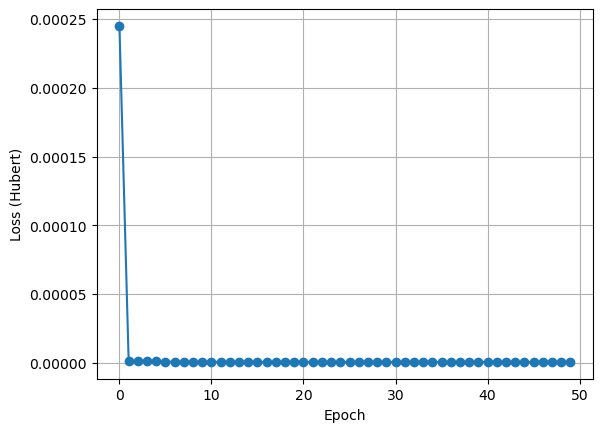

In [13]:
plt.plot(history.history["loss"], "o-", label = "Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (Hubert)")
plt.grid('on')


## Test the model

In [14]:
model.evaluate(X_test, y_test)

15641/15641 ━━━━━━━━━━━━━━━━━━━━ 4s 232us/step - loss: 1.0855e-06


1.0228196742900764e-06

## Save the model

In [53]:
# Save the model
model.save("Barite_50_Model_additional_species.keras")